## **Все вычисления проводились на google colab**

In [0]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, AffinityPropagation
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae_score
from sklearn.linear_model import LinearRegression
import pickle

In [0]:
%matplotlib inline 

Загружаем обучающую выборку

In [16]:
    from google.colab import files

    uploaded = files.upload()

    for fn in uploaded.keys():
       print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving CL_megafon_Cup IT_2020_final_data.csv to CL_megafon_Cup IT_2020_final_data.csv
User uploaded file "CL_megafon_Cup IT_2020_final_data.csv" with length 5399471 bytes


In [0]:
df= pd.read_csv('CL_megafon_Cup IT_2020_final_data.csv', sep = ';')

Преобрабзуем типы начала и конца событий к datetime.  
Формируем целевой признак

In [0]:
df['time_start'] = pd.to_datetime(df['time_start'])
df['time_end'] = pd.to_datetime(df['time_end'])
df['target'] = df['time_end'] - df['time_start']
df['target'] = df['target'].apply(lambda x: x.days*60*24 +math.ceil(x.seconds/60)).astype('int')

Посмотрим на общую картину и оценим зашумлённость данных

ERROR! Session/line number was not unique in database. History logging moved to new session 59


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



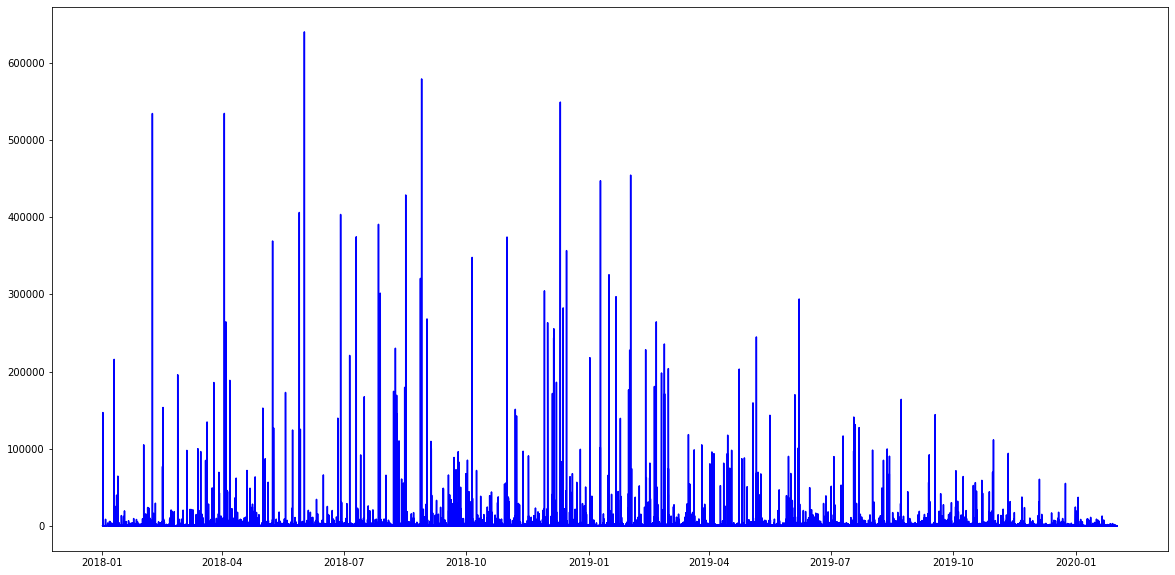

In [19]:
df.sort_values('time_start', inplace = True)
fig, ax = plt.subplots(figsize = (20, 10))

ax.plot(df['time_start'], df['target'], color = 'blue')

Можно заметить большое количество выбрасов и сообвественно сильную дисперсию.  
Удалим 10%-ый перцентить для сглаживания этой ситуации

In [0]:
index = df[df['time_start']<pd.to_datetime('2020-01-01')].sort_values('target')[int(df.shape[0]*0.90):].index
df.drop(index, inplace = True)

Очевидно, что главной задачей, на данном этапе построения модели является кластеризация. Кластеризуем данные по их географическому признаку(т е по долготе и широте). выбор такого способа кластеризации связан с простоой классификации нового объекта к уже имеющимся группам. Для этого в дальнейшем для каждого кластера будут расчитываться их центры масс, и новый входной объект будет относиться с классу с ближайшим центром масс.

Для начала взглянем на общее распределение событий в зависимости от географических координат

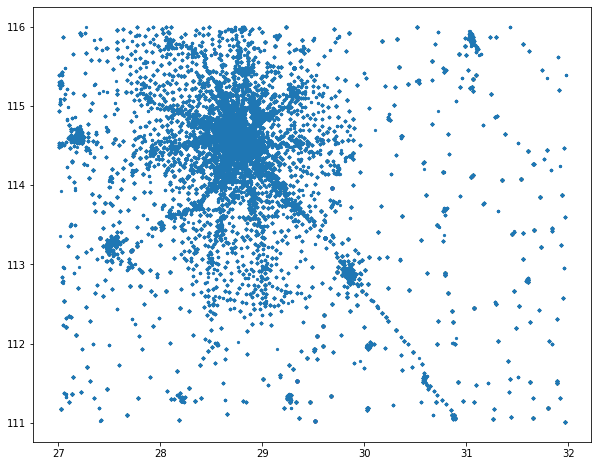

In [37]:
 _, ax = plt.subplots(figsize = (10, 8))
 plt.scatter(df['place_latitude'], df['place_longitude'],  s=5, marker='o')

На первом этапе кластеризации используем алгоритм DBSCSN с гиперпараметром eps=0.012, что примерно эквиволентно радиусу охвата в один километр.

In [21]:
dbscan = DBSCAN(eps = 0.012)
dbscan.fit(df[['place_latitude', 'place_longitude']])

DBSCAN(algorithm='auto', eps=0.012, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

Выделим большие кластеры и отобразим их

In [38]:
df['sector_1']= dbscan.labels_
df['sector_1'].value_counts()

 1       12023
-1        1534
 598       539
 7         483
 161       370
         ...  
 2218        5
 1868        5
 1996        5
 2091        5
 24          5
Name: sector_1, Length: 2469, dtype: int64

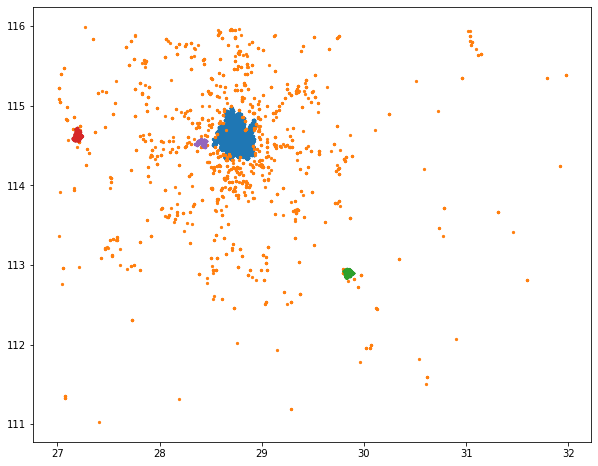

In [39]:
big_clusters = df['sector_1'].value_counts().index[:5]
_, ax = plt.subplots(figsize = (10, 8))
for i in big_clusters:
  plt.scatter(df[df['sector_1']==i]['place_latitude'], df[df['sector_1']==i]['place_longitude'],  s=5, marker='o' )

Оставшиеся большие кластеры вторично разобъём алгоритмом Affinity Propagation

In [40]:
big_cluster_lubels = {}
for cluster_index in big_clusters:
  AP = AffinityPropagation(affinity= 'euclidean', convergence_iter=15, copy=True, damping=0.95, max_iter=200, preference=None, verbose=False)
  AP.fit(df[df['sector_1']==cluster_index][['place_latitude', 'place_longitude']]) 
  big_cluster_lubels[str(cluster_index)] = AP.labels_

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning:

Affinity propagation did not converge, this model will not have any cluster centers.



In [0]:
big_cluster_lubels

{'-1': array([ 7,  9,  0, ...,  1, 11,  8]),
 '1': array([-1, -1, -1, ..., -1, -1, -1]),
 '161': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0,

Как можно заметить, алогоритм на этапе вторичной кластеризации сошелся не на всех кластерах.  
Присвоим каждому подклассу в кластерах, на которых алгоритм сошёлся свой идентификационных номер

In [41]:
df['sector_1'].max()

2467

Преобразовываем Первую группу

In [0]:
for i in range(len(big_cluster_lubels['-1'])):
  big_cluster_lubels['-1'][i] = (big_cluster_lubels['-1'][i]+1)*-1

In [0]:
ind = df[df['sector_1']==-1].index
df.loc[ind, 'sector_1'] = big_cluster_lubels['-1']

Преобразовываем пятую группу секторов

In [0]:
for i in range(len(big_cluster_lubels['7'])):
  big_cluster_lubels['7'][i] = big_cluster_lubels['7'][i]+2456

In [0]:
ind = df[df['sector_1']==7].index
df.loc[ind, 'sector_1'] = big_cluster_lubels['7']

### **Формирование сезонных параметров**

In [0]:
df['year'] = df['time_start'].apply(lambda x: x.year)
df['month'] = df['time_start'].apply(lambda x: x.month)

In [0]:
grouped = df.groupby('year')['month'].value_counts()
grouped.sort_index(inplace = True)

In [56]:
trace0 = go.Scatter(x= grouped[2018].index, y=grouped[2018].values, name='2018')
trace1 = go.Scatter(x= grouped[2019].index, y=grouped[2019].values, name='2019')
trace2 = go.Scatter(x= grouped[2020].index, y=grouped[2020].values, name='2020')

fig = go.Figure(data = [trace0, trace1, trace2])
iplot(fig)

На данном графике отображена зависимость количества событий от номера месяца. Можно заметить что наблюдаются некоторые сезонности, а в частности в первых месяцах событий меньше, чем в середине года. Исходя из наблюдаемых сезонностей добавим ещё несколько признаков.

In [0]:
df['week_day'] = df['time_start'].apply(lambda x: x.isoweekday())
df['day'] = df['time_start'].apply(lambda x: x.day)
df['hour'] = df['time_start'].apply(lambda x: x.hour)

### **Формирование дополнительных признаков.**

Сформируем следующие признаки:
1. среднее значение длительности сбоя по каждому сектору (кластеру)
2. минимальное значение длительности сбоя по каждому сектору 
3. максимальное значение длительности сбоя по каждому сектору 
4. мода  длительности сбоя по каждому сектору 

In [0]:
def sector_mean(x):
    start = df.loc[x]['time_start']
    sector = df.loc[x]['sector']
    if start >= pd.to_datetime('2018-02-01'):
        #print('yes')
        rez = df[(df['sector'] == sector)&(df['time_start'] < (start - pd.offsets.MonthBegin(1)))&
                 (df['time_start'] >= (start - pd.offsets.MonthBegin(2)))]['target'].mean()
        #print((start - pd.offsets.MonthBegin(1)) , '\t', (start - pd.offsets.MonthBegin(2)))
    else:
        #print('No')
        rez = df[(df['sector'] == sector) & (df['time_start'] < (start - pd.offsets.MonthBegin(0))) &
                 (df['time_start'] >= (start - pd.offsets.MonthBegin(1)))]['target'].mean()
        #print((start - pd.offsets.MonthBegin(0)), '\t', (start - pd.offsets.MonthBegin(1)))
        
    return rez

def sector_min(x):
    start = df.loc[x]['time_start']
    sector = df.loc[x]['sector']
    if start >= pd.to_datetime('2018-02-01'):
        #print('yes')
        rez = df[(df['sector'] == sector)&(df['time_start'] < (start - pd.offsets.MonthBegin(1)))&
                 (df['time_start'] >= (start - pd.offsets.MonthBegin(2)))]['target'].min()
        #print((start - pd.offsets.MonthBegin(1)) , '\t', (start - pd.offsets.MonthBegin(2)))
    else:
        #print('No')
        rez = df[(df['sector'] == sector) & (df['time_start'] < (start - pd.offsets.MonthBegin(0))) &
                 (df['time_start'] >= (start - pd.offsets.MonthBegin(1)))]['target'].min()
        #print((start - pd.offsets.MonthBegin(0)), '\t', (start - pd.offsets.MonthBegin(1)))
        
    return rez

def sector_max(x):
    start = df.loc[x]['time_start']
    sector = df.loc[x]['sector']
    if start >= pd.to_datetime('2018-02-01'):
        #print('yes')
        rez = df[(df['sector'] == sector)&(df['time_start'] < (start - pd.offsets.MonthBegin(1)))&
                 (df['time_start'] >= (start - pd.offsets.MonthBegin(2)))]['target'].max()
        #print((start - pd.offsets.MonthBegin(1)) , '\t', (start - pd.offsets.MonthBegin(2)))
    else:
        #print('No')
        rez = df[(df['sector'] == sector) & (df['time_start'] < (start - pd.offsets.MonthBegin(0))) &
                 (df['time_start'] >= (start - pd.offsets.MonthBegin(1)))]['target'].max()
        #print((start - pd.offsets.MonthBegin(0)), '\t', (start - pd.offsets.MonthBegin(1)))
        
    return rez

def sector_mode(x):
    start = df.loc[x]['time_start']
    sector = df.loc[x]['sector']
    if start >= pd.to_datetime('2018-02-01'):
        #print('yes')
        rez = df[(df['sector'] == sector)&(df['time_start'] < (start - pd.offsets.MonthBegin(1)))&
                 (df['time_start'] >= (start - pd.offsets.MonthBegin(2)))]['target'].mode()
        #print((start - pd.offsets.MonthBegin(1)) , '\t', (start - pd.offsets.MonthBegin(2)))
    else:
        #print('No')
        rez = df[(df['sector'] == sector) & (df['time_start'] < (start - pd.offsets.MonthBegin(0))) &
                 (df['time_start'] >= (start - pd.offsets.MonthBegin(1)))]['target'].mode()
        #print((start - pd.offsets.MonthBegin(0)), '\t', (start - pd.offsets.MonthBegin(1)))
        
    return rez

In [59]:
df['ind'] = df.index
df.head(1)

,time_start,time_end,place_latitude,place_longitude,target,sector_1,year,month,week_day,day,hour,ind
73313,2018-01-01 04:35:56,2018-01-01 12:28:19,28.227964,113.565739,473,0,2018,1,1,1,4,73313


In [0]:
df.columns = ['time_start', 'time_end', 'place_latitude', 'place_longitude', 'target',
       'sector', 'year', 'month', 'week_day', 'day', 'hour', 'ind']

In [0]:
df['mean_feat'] = df['ind'].apply(sector_mean)

In [0]:
 df['min_feat'] = df['ind'].apply(sector_min) 

In [0]:
df['max_feat'] = df['ind'].apply(sector_max)

In [0]:
mode_feat = df['ind'].apply(sector_mode)
df['mode_feat'] = mode_feat[0]

In [0]:
df['mean_feat'].fillna(df['mean_feat'].mean(), inplace = True)
df['min_feat'].fillna(df['min_feat'].mean(), inplace = True)
df['max_feat'].fillna(df['max_feat'].mean(), inplace = True)
df['mode_feat'].fillna(df['mode_feat'].mean(), inplace = True)

### **Обучение**

#### Обучим случайный лес

In [0]:
# MAPE score 
def mape_score (y_true, y_pred):
  return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [0]:
def data_transform(df):
  data = df.copy()
  index = data[data['time_start']<pd.to_datetime('2020-01-31')].sort_values('target')[int(data.shape[0]*0.90):].index
  data.drop(index, inplace = True)

  data_train = data[data['time_start']<pd.to_datetime('2020-01-01')]
  data_test = data[data['time_start'] >=pd.to_datetime('2020-01-01')]

  y_train = data_train['target']
  X_train = data_train.drop(['time_start', 'time_end', 'target'], axis = 1)
  y_test = data_test['target']
  X_test = data_test.drop(['time_start', 'time_end', 'target'], axis = 1)
  return X_train, y_train, X_test, y_test

Случайный лес

In [156]:
X_train, y_train, X_test, y_test = data_transform(df)
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mape = mape_score(y_test, y_pred)
print (mape)

150.7691819006823


#### Линейная регресси

In [159]:
X_train, y_train, X_test, y_test = data_transform(df)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mape = mape_score(y_test, y_pred)
print (mape)

132.56926836472974


#### XGBoost

In [0]:
from sklearn.model_selection import TimeSeriesSplit

In [0]:
from xgboost import XGBRegressor

In [160]:
X_train, y_train, X_test, y_test = data_transform(df)
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
mape = mape_score(y_test, y_pred)
print ( mape)



/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:24:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
135.6130255438597


На графике ниже синим цветом изображены реальные значения длительности сбоев за прогнозируемый месяц, красным же цветом изображены прогнозы нашей модели

In [161]:
trace0 = go.Scatter(x=np.arange(len(y_test)), y=y_test.values, name='real')
trace1 = go.Scatter(x= np.arange(len(y_test)), y=y_train, name='prediction')

fig = go.Figure(data = [trace0, trace1])
iplot(fig)

Резюмируя, лучшую оценку в 135,6 процентов показал XGBoost, напомню, что мы использовали метрику MAPE.

### Сформируем класс для использования модели в продакшене 

In [0]:
sectors_data  =pd.DataFrame()

In [0]:
features = ['place_latitude', 'place_longitude', 'mean_feat', 'min_feat', 'max_feat', 'mode_feat']
for feat in features:
  sectors_data[feat] = df.groupby('sector')[feat].mean()

In [168]:
sectors_data.head(2)

,place_latitude,place_longitude,mean_feat,min_feat,max_feat,mode_feat
sector,,,,,,
-18,28.475244,115.165856,210.264536,69.061329,559.107978,74.124915
-17,30.238002,111.975593,111.618084,62.885186,293.609521,69.679586


In [169]:
df.head(2)

,time_start,time_end,place_latitude,place_longitude,target,sector,year,month,week_day,day,hour,ind,mean_feat,min_feat,max_feat,mode_feat
73313,2018-01-01 04:35:56,2018-01-01 12:28:19,28.227964,113.565739,473,0,2018,1,1,1,4,73313,187.87352,79.633746,592.24338,94.732412
17836,2018-01-01 09:30:40,2018-01-01 10:37:56,28.871813,114.592832,68,1,2018,1,1,1,9,17836,187.87352,79.633746,592.24338,94.732412


Класс **Regressor** будет отвечать за классификацию нового наблюдения к уже имеющимся коастерам по их центру масс. Также этот класс отвечает за передачу тестовому датасету некоторых параметров последнего наблюдаемого месяца. Ну и конечно, основной задачей будет поучение прогноза от сериализованной обученной модели.

In [0]:
class Regressor():
  def __init__(self, learned_model, sector_feats):
    self.xgb =learned_model
    self.sector_feats = sector_feats
   
  def init_data(self, data):
    self.data = data


  def min_long(self, x):
    latitude = self.data.loc[x]['place_latitude']
    longitude = self.data.loc[x]['place_longitude']
    self.sector_feats['sub_latitude'] = self.sector_feats['place_latitude'].apply(lambda x1: (x1-latitude)**2)
    self.sector_feats['sub_longitude'] = self.sector_feats['place_longitude'].apply(lambda x1: (x1-longitude)**2)
    self.sector_feats['rez'] = self.sector_feats['sub_latitude'] + self.sector_feats['sub_longitude']
    rez = self.sector_feats.sort_values('rez').index[0]
    return rez

  def processing(self):
    self.data['ind'] = self.data.index
    self.data['sector_1'] = self.data['ind'].apply(self.min_long)
    print(self.data['sector_1'].values)
    print(self.data.columns)
    self.sector_feats['sector_1'] = self.sector_feats.index
    self.data = self.data.merge(self.sector_feats[['sector_1','mean_feat','min_feat',	'max_feat',	'mode_feat']], on = 'sector_1',  how = 'left')
    print(self.data.columns)
    self.data.drop(['sector_1', 'ind'], axis = 1, inplace = True)
    print(self.data.columns)

  def create_time_feats(self):
    self.data['time_start'] = pd.to_datetime(self.data['time_start'])
    self.data['year'] = self.data['time_start'].apply(lambda x: x.year)
    self.data['month'] = self.data['time_start'].apply(lambda x: x.month)
    self.data['week_day'] = self.data['time_start'].apply(lambda x: x.isoweekday())
    self.data['day'] = self.data['time_start'].apply(lambda x: x.day)
    self.data['hour'] =self.data['time_start'].apply(lambda x: x.hour)
  
  def predicting(self):
    self.data.drop('time_start', axis = 1, inplace = True)
    print(self.data.columns)
    return self.xgb.predict(self.data)

Сериализуем данные

In [0]:
regressor_1 = Regressor(lr, sectors_data)
filename = 'lr_model.sav'
pickle.dump(regressor_1, open(filename, 'wb'))